In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
sys.path.append("../")

In [3]:
from Transformers import UNetDataset, ChannelsFirst, ToTensor, Rescale, splitter

In [4]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT
train_test = os.path.join(data_dir, "train_validation_test")

In [5]:
data = np.load(os.path.join(train_test,"Xy_train+val_clean_300_24_10_25.npz"))
x = data["x"]
y = data['y']
dist = data['dist']
class_dist = np.unique(data['dist'], return_inverse=True)[1]

In [6]:
composed = transforms.Compose([Rescale(.25), ChannelsFirst(), ToTensor()])

In [7]:
dataset = UNetDataset(x, y, transform=composed, dist = dist[...,np.newaxis])

In [8]:
data_loaders, data_lengths = splitter(dataset, validation_split=0.2, batch=16, workers=4)

In [9]:
torch.cuda.empty_cache() 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [12]:
model = cUNet(out_size=1)

In [13]:
criterion_mask = dice_loss

In [14]:
criterion_class = nn.MSELoss()

In [15]:
model.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [16]:
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
epochs = 50

In [18]:
coeff_mask = 0.60

In [19]:
for epoch in range(epochs):
    print("Epoch {}/{}\n".format(epoch+1, epochs))
    print('-'* 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)
        else:
            model.train(False)
            
        running_loss = 0.0
        for i, batch in enumerate(data_loaders[phase]):
            inputs = batch['image'].float().to(device)
            labels_mask = batch['mask'].float().to(device)
            labels_dist = batch['dist'].float().to(device)
            #print(inputs.is_cuda, labels_mask.is_cuda, labels_dist.is_cuda)
            optimizer.zero_grad()
            out_mask, out_class  = model(inputs)
            #print(out_mask.is_cuda)
            #print(out_class.is_cuda)
            loss_mask = criterion_mask(out_mask, labels_mask)
            loss_class = criterion_class(out_class, labels_dist)
            loss = coeff_mask * loss_mask + (1-coeff_mask) * loss_class
            #print(loss_mask, loss_class)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))
print('Finished Training')

Epoch 1/50

----------
train Loss: 2.8463
val Loss: 1.9716
Epoch 2/50

----------
train Loss: 2.0994
val Loss: 1.9492
Epoch 3/50

----------
train Loss: 2.0688
val Loss: 1.9637
Epoch 4/50

----------
train Loss: 2.0900
val Loss: 2.0703
Epoch 5/50

----------
train Loss: 2.1191
val Loss: 1.9771
Epoch 6/50

----------
train Loss: 2.0872
val Loss: 1.9518
Epoch 7/50

----------
train Loss: 2.0719
val Loss: 1.9403
Epoch 8/50

----------
train Loss: 2.0793
val Loss: 1.9360
Epoch 9/50

----------
train Loss: 2.0640
val Loss: 2.0553
Epoch 10/50

----------
train Loss: 2.0811
val Loss: 2.0608
Epoch 11/50

----------
train Loss: 2.0537
val Loss: 1.9653
Epoch 12/50

----------
train Loss: 2.0305
val Loss: 1.9568
Epoch 13/50

----------
train Loss: 2.0342
val Loss: 1.9241
Epoch 14/50

----------
train Loss: 2.0563
val Loss: 1.9334
Epoch 15/50

----------
train Loss: 2.0789
val Loss: 1.9865
Epoch 16/50

----------
train Loss: 2.0316
val Loss: 1.9137
Epoch 17/50

----------
train Loss: 2.0478
val Lo

In [20]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation.pkl".format(epochs, coeff_mask)

In [21]:
torch.save(model.state_dict(), model_name)

In [22]:
model_inference = cUNet(out_size=1)

In [23]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [25]:
test_data = np.load(os.path.join(train_test,"Xy_test_clean_300_24_10_25.npz"))
x_test = test_data["x"]
y_test = test_data['y']
dist_test = test_data['dist']
dist_test_idx = np.unique(dist_test, return_inverse=True)[1]

In [26]:
test_dataset = UNetDataset(x_test, y_test, transform=composed, dist = dist_test)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [27]:
model_inference = model.eval()

In [28]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [29]:
import matplotlib.pyplot as plt

In [30]:
dist_dict = {str(idx):cl  for (cl, idx) in 
             zip(np.unique(dist_test), np.unique(dist_test_idx))}

batch 1
1: true_dist: 10, pred_dist: [9.982794]


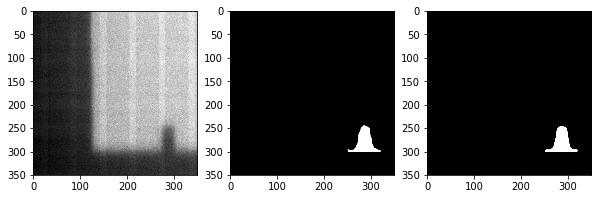

2: true_dist: 10, pred_dist: [10.209704]


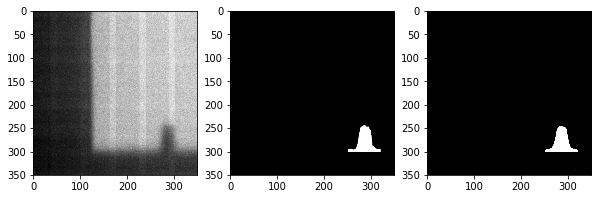

3: true_dist: 10, pred_dist: [10.010829]


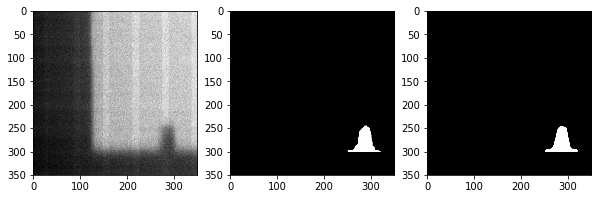

4: true_dist: 4, pred_dist: [4.1267776]


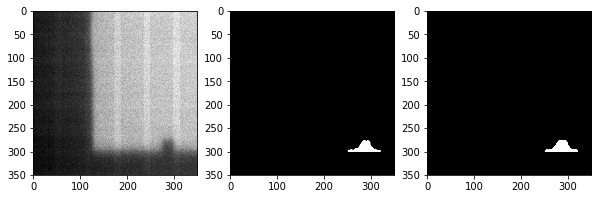

5: true_dist: 25, pred_dist: [25.297207]


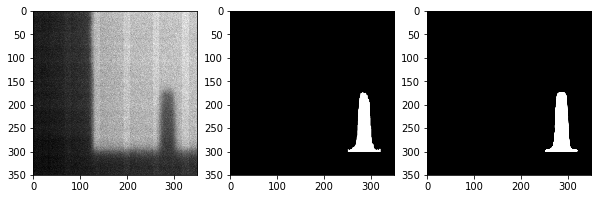

6: true_dist: 25, pred_dist: [25.207783]


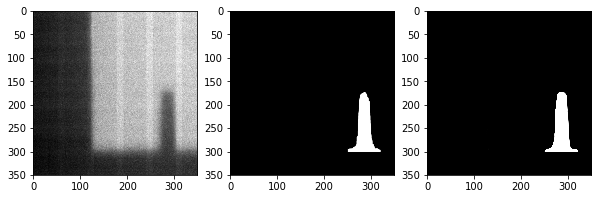

7: true_dist: 25, pred_dist: [25.132496]


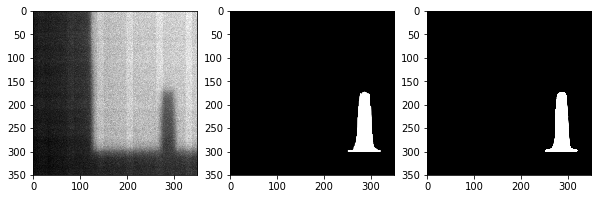

8: true_dist: 10, pred_dist: [10.467565]


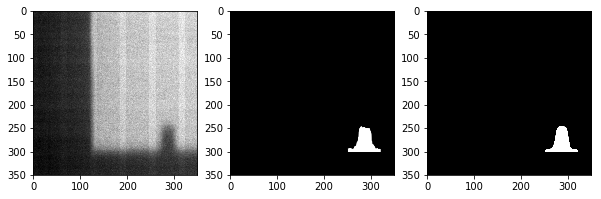

9: true_dist: 2, pred_dist: [2.247524]


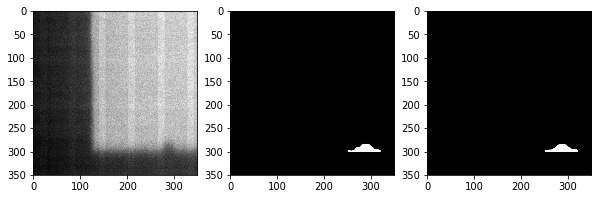

10: true_dist: 10, pred_dist: [10.282603]


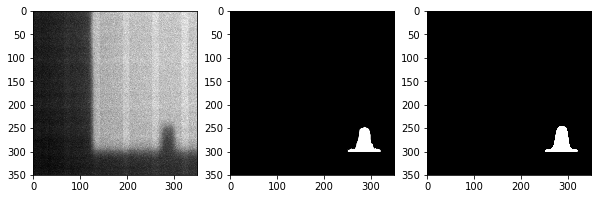

11: true_dist: 2, pred_dist: [2.082031]


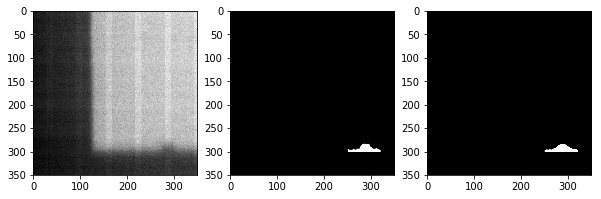

12: true_dist: 2, pred_dist: [2.3379345]


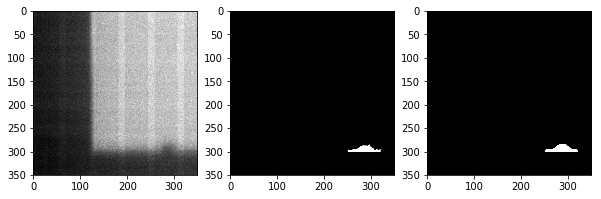

13: true_dist: 25, pred_dist: [25.26882]


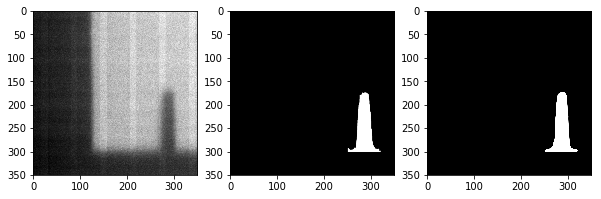

14: true_dist: 10, pred_dist: [10.077493]


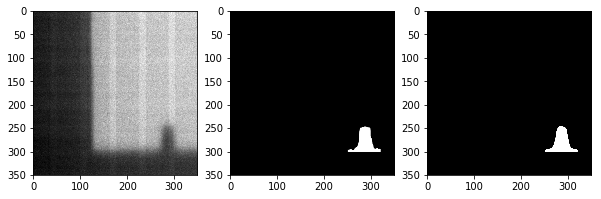

15: true_dist: 10, pred_dist: [10.184095]


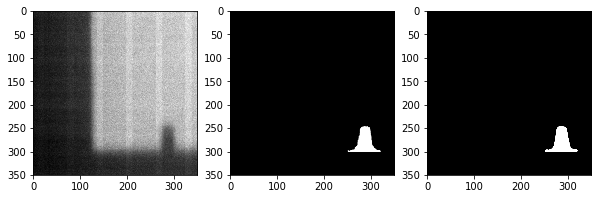

16: true_dist: 4, pred_dist: [4.1443977]


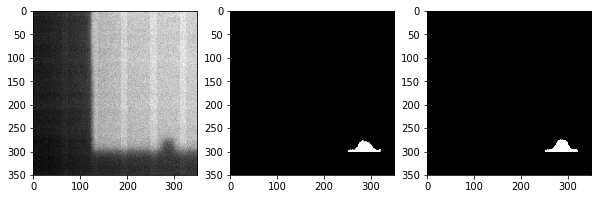

batch 2
1: true_dist: 4, pred_dist: [4.1340504]


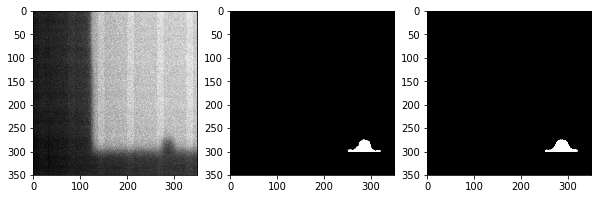

2: true_dist: 4, pred_dist: [3.8801491]


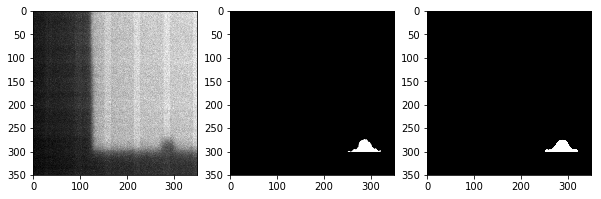

3: true_dist: 2, pred_dist: [2.021488]


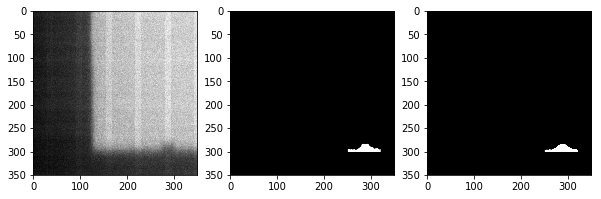

4: true_dist: 10, pred_dist: [10.004214]


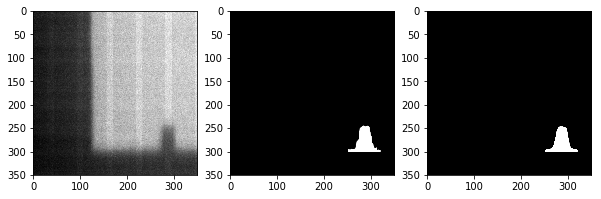

5: true_dist: 2, pred_dist: [2.0640497]


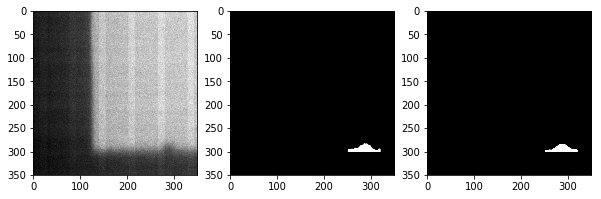

6: true_dist: 4, pred_dist: [4.0892434]


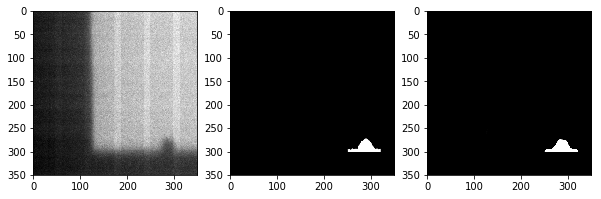

7: true_dist: 25, pred_dist: [25.14764]


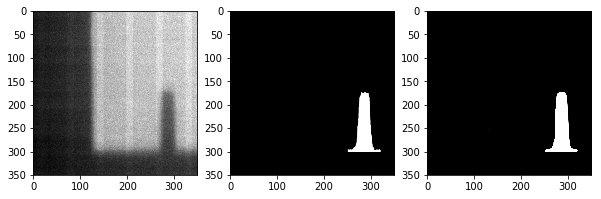

8: true_dist: 10, pred_dist: [10.107315]


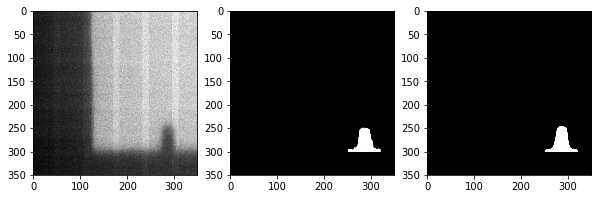

9: true_dist: 4, pred_dist: [4.128543]


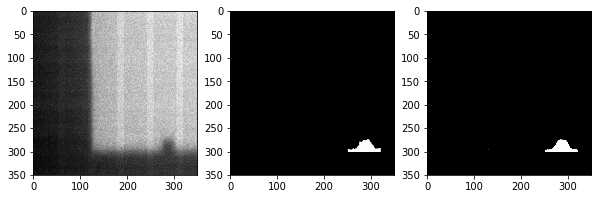

10: true_dist: 2, pred_dist: [2.2490277]


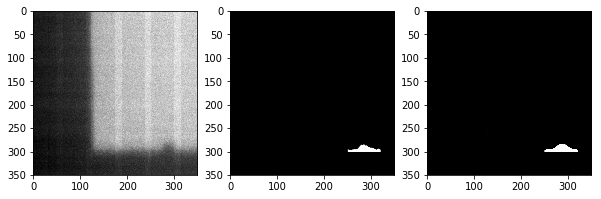

11: true_dist: 2, pred_dist: [2.0875564]


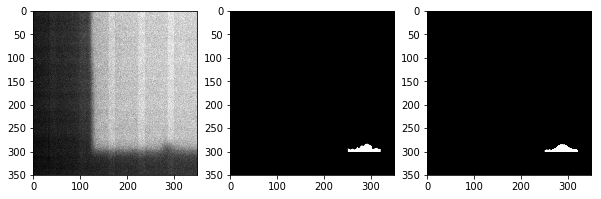

12: true_dist: 25, pred_dist: [25.145214]


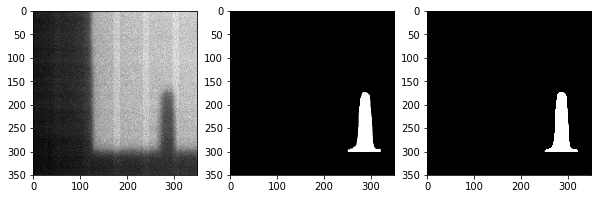

13: true_dist: 25, pred_dist: [25.43212]


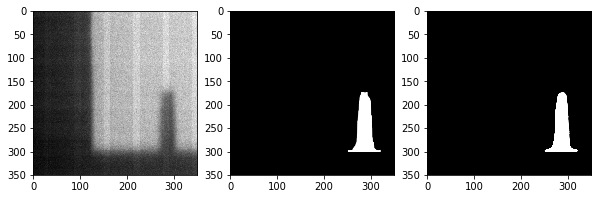

14: true_dist: 2, pred_dist: [2.1979864]


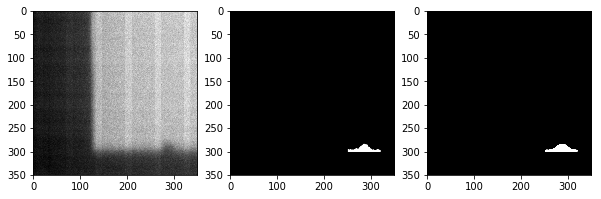

15: true_dist: 4, pred_dist: [4.088157]


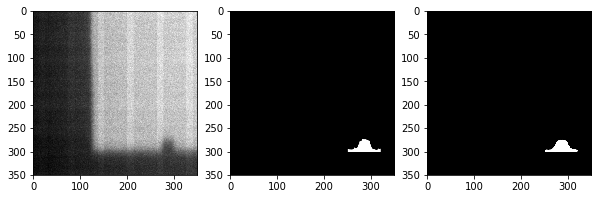

16: true_dist: 10, pred_dist: [10.298009]


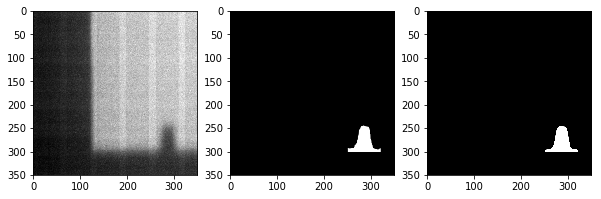

In [31]:
for i, batch in enumerate(test_data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [32]:
y_test = []
y_pred = []
for i, batch in enumerate(test_data_loader):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        y_test.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15


In [33]:
15*16

240

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
mean_squared_error(y_test, y_pred)

0.04714779265286542

In [36]:
mean_absolute_error(y_test, y_pred)

0.17415061990420025